# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

c:\Users\lvand\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Add any additional import statements you need here
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
from nltk.tokenize import word_tokenize

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/lvand/OneDrive/Desktop/Applied Text Mining/M2/M1 Assignment Data/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [21]:
# Set your data location
data_location = "C:/Users/lvand/OneDrive/Desktop/Applied Text Mining/M2/M1 Assignment Data/M1 Results/"

# Subfolders for the lyrics and Twitter data
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")

# Dictionary to store the lyrics data
lyrics_data = {}

# Read lyrics data
for artist_folder in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_folder)
    
    if os.path.isdir(artist_path):
        lyrics_data[artist_folder] = {}
        for song_file in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song_file)
            with open(song_path, 'r', encoding='utf-8') as file:
                song_name = song_file.replace(".txt", "")
                lyrics_data[artist_folder][song_name] = file.read()

# Dictionary to store Twitter descriptions
twitter_data = defaultdict(list)

# Separate artists
artist_files = {
    'cher' : 'cher_followers_data.txt',
    'robyn' : 'robynkonichiwa_followers_data.txt'
    }

# Read Twitter data
for artist, file_name in artist_files.items():
    artist_path = os.path.join(twitter_folder, file_name)
    
    if os.path.isfile(artist_path):
        with open(artist_path, 'r') as file:
            descriptions = file.readlines()
            twitter_data[artist] = [desc.strip() for desc in descriptions]

# Convert to DF
twitter = pd.DataFrame([
    {'artist': artist, 'Description': description}
    for artist, descriptions in twitter_data.items()
    for description in descriptions
])

# Example usage:
print(f"Lyrics data for artists: {list(lyrics_data.keys())[:2]}")
print(f"Twitter descriptions files: {list(artist_files)[:]}")

Lyrics data for artists: ['cher', 'robyn']
Twitter descriptions files: ['cher', 'robyn']


In [5]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Data Location for new files
data_location2 = "C:/Users/lvand/OneDrive/Desktop/Applied Text Mining/M6/ADS-509_Assignment6"

# Define paths for sentiment files
positive_words_file = os.path.join(data_location2, "positive-words.txt")
negative_words_file = os.path.join(data_location2, "negative-words.txt")
tidy_text_file = os.path.join(data_location2, "tidytext_sentiments.txt")

# Dictionary to store word sentiments
word_sentiments = {}

# Read positive words and assign score +1
with open(positive_words_file, 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word and not word.startswith(';'):
            word_sentiments[word] = 1

# Read negative words and assign score -1
with open(negative_words_file, 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word and not word.startswith(';'):
            word_sentiments[word] = -1

# Read tidytext sentiment file 
tidytext_sentiments_df = pd.read_csv(tidy_text_file, sep='\t', header=0)  

# Process the tidytext file to assign scores
for index, row in tidytext_sentiments_df.iterrows():
    word = row['word']
    sentiment = row['sentiment']
    
    # Convert the sentiment to a numerical score
    if sentiment == 'positive':
        word_sentiments[word] = 1
    elif sentiment == 'negative':
        word_sentiments[word] = -1


In [6]:
# Data check
print(f"Sentiment score for 'happy': {word_sentiments.get('happy', 'Not Found')}")
print(f"Sentiment score for 'sad': {word_sentiments.get('sad', 'Not Found')}")

Sentiment score for 'happy': 1
Sentiment score for 'sad': -1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [7]:
# Function to calculate sentiment score for a given song
def calculate_sentiment(lyrics, word_sentiments):
    sentiment_score = 0
    words = lyrics.split()  # tokenization for spaces
    for word in words:
        word = word.lower().strip(",.!?;:()\"")  # fixing word case and punctuation
        if word in word_sentiments:
            sentiment_score += word_sentiments[word]
    return sentiment_score

# Dictionary to store sentiment scores for each song
song_sentiments = {}

# Calculate sentiment for each artist's songs
for artist, songs in lyrics_data.items():
    song_sentiments[artist] = {}
    for song, lyrics in songs.items():
        song_sentiments[artist][song] = calculate_sentiment(lyrics, word_sentiments)

In [8]:
# Convert to df for clarity
sentiment_df = pd.DataFrame([
    {'artist': artist, 'song': song, 'sentiment_score': score}
    for artist, songs in song_sentiments.items()
    for song, score in songs.items()
])

# Display the sentiment scores
print(sentiment_df)

    artist                           song  sentiment_score
0     cher                 cher_88degrees               10
1     cher  cher_adifferentkindoflovesong               37
2     cher                  cher_afterall               -5
3     cher                     cher_again               -1
4     cher                     cher_alfie               11
..     ...                            ...              ...
415  robyn   robyn_wedancetothebeat114528               68
416  robyn        robyn_wheredidourlovego               10
417  robyn             robyn_whosthatgirl               25
418  robyn       robyn_witheveryheartbeat               -4
419  robyn    robyn_youvegotthatsomething                5

[420 rows x 3 columns]


Q: Overall, which artist has the higher average sentiment per song? 

A: The artist with the highest average sentiment is Robyn with 9.096, as seen below.

In [9]:
# Calculate the average sentiment score per artist
average_sentiment_per_artist = sentiment_df.groupby('artist')['sentiment_score'].mean()

# Print the results
print("Average sentiment score per artist:")
print(average_sentiment_per_artist)

Average sentiment score per artist:
artist
cher     6.873418
robyn    9.096154
Name: sentiment_score, dtype: float64


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs in Cher's discography that have the highest sentiments are Love and Understanding, I found you Love, and Perfection. This is likey because the songs are centered around romance and love, which is deemed a more positive theme and sentiment. In contrast, Cher's lowest scoring songs in terms of sentiment are Outrageous, Bang Bang (My Baby Shot Me Down), and Bang-Bang. These songs contain more language that would be deemed as having a negative connotation, resulting in a lower score.

In [10]:
# Select the first artist in the dataset (Cher)
cher = sentiment_df['artist'].unique()[0]

# Filter the sentiment scores for Cher
artist_songs_df = sentiment_df[sentiment_df['artist'] == cher]

# Sort by sentiment score
sorted_songs = artist_songs_df.sort_values(by='sentiment_score', ascending=False)

# Get the top 3 and bottom 3 songs
top_3_songs = sorted_songs.head(3)
bottom_3_songs = sorted_songs.tail(3)

# Print the lyrics of the top 3 and bottom 3 songs
print(f"\nTop 3 Songs by Sentiment for {cher}:")
for index, row in top_3_songs.iterrows():
    song = row['song']
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data[cher][song]}")

print(f"\nBottom 3 Songs by Sentiment for {cher}:")
for index, row in bottom_3_songs.iterrows():
    song = row['song']
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data[cher][song]}")


Top 3 Songs by Sentiment for cher:

Song: cher_loveandunderstanding
Lyrics:
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease th

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Robyn's top and bottom songs both include a song repeated. This could be for a number of reasons such as, remixes, databases issues on AtoZ Lyrics, duplicate entries on AtoZ lyrics, etc. The top three songs with the highest sentiments are Love Is Free, We Dance To The Beat, We Dance To The Beat 114258. These songs include lyrics that would be attributed to more positive feelings and an up-beat mood. Whereas the three lowest sentiment songs are Criminal Intent, Don't Fucking Tell Me What To Do, and Don't Fucking Tell Me What To Do 114520. In contrast, by the titles alone, we can tell that these songs have a more negative sounding theme, likely resulting in more negative lyrical content.

In [11]:
# Select the first artist in the dataset (Robyn)
robyn = sentiment_df['artist'].unique()[1]

# Filter the sentiment scores for Cher
artist_songs_df = sentiment_df[sentiment_df['artist'] == robyn]

# Sort by sentiment score
sorted_songs = artist_songs_df.sort_values(by='sentiment_score', ascending=False)

# Get the top 3 and bottom 3 songs
top_3_songs = sorted_songs.head(3)
bottom_3_songs = sorted_songs.tail(3)

# Print the lyrics of the top 3 and bottom 3 songs
print(f"\nTop 3 Songs by Sentiment for {robyn}:")
for index, row in top_3_songs.iterrows():
    song = row['song']
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data[robyn][song]}")

print(f"\nBottom 3 Songs by Sentiment for {robyn}:")
for index, row in bottom_3_songs.iterrows():
    song = row['song']
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data[robyn][song]}")


Top 3 Songs by Sentiment for robyn:

Song: robyn_loveisfree
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

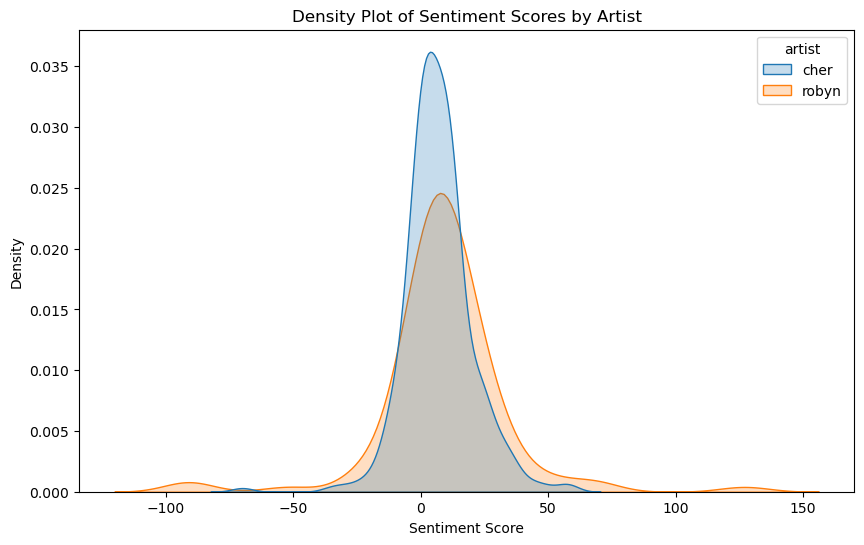

In [12]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Density plot of sentiment scores for both artists
sns.kdeplot(data=sentiment_df, x='sentiment_score', hue='artist', fill=True, common_norm=False)

# Add titles and labels
plt.title('Density Plot of Sentiment Scores by Artist')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

# Show the plot
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

Q: What is the average sentiment of your two artists? 

A: The average sentiment of Cher is 0.2 and the average sentiment of Robyn is 0.1 based on the emojis within the descriptions of tweets.

In [26]:
# Define positive and negative emojis
positive_emojis = {
    '😂', '😀', '😁', '😆', '😇', '😍', '🥳', '🎉', '✨', '🙏', '🤪', '🥰'
}

negative_emojis = {
    '😞', '😰', '😒', '😭', '😡', '😠', '😩', '💔', '👎', '🤬', '😨', '😩'
}

# Function to score sentiment for each description
def score_sentiment(description):
    score = 0
    for emoji in positive_emojis:
        score += description.count(emoji)  # +1 for each positive emoji
    for emoji in negative_emojis:
        score -= description.count(emoji)  # -1 for each negative emoji
    return score

# Apply the sentiment scoring function to each description
twitter['sentiment_score'] = twitter['Description'].apply(score_sentiment)

# Calculate the average sentiment score for each artist
average_sentiment_scores = twitter.groupby('artist')['sentiment_score'].mean().reset_index()

# Print average sentiment scores for each artist
for index, row in average_sentiment_scores.iterrows():
    print(f"Average sentiment score for {row['artist']}: {row['sentiment_score']:.2f}")

Average sentiment score for cher: 0.02
Average sentiment score for robyn: 0.01



Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The two artists share the same most popular positive and negative emojis across the tweets provided. The most popular positive emoji is ✨, while the most popular negative  emoji is 💔



In [27]:
# Function to count emojis for an artist
def count_emojis(descriptions, emoji_set):
    emoji_counter = Counter()
    for description in descriptions:
        for emoji in emoji_set:
            emoji_counter[emoji] += description.count(emoji)
    return emoji_counter

# Dictionary to store most popular emojis
most_popular_emojis = {}

# Iterate through artists
for artist, descriptions in twitter_data.items():
    # Count positive and negative emojis
    positive_count = count_emojis(descriptions, positive_emojis)
    negative_count = count_emojis(descriptions, negative_emojis)
    
    # Get the most common emojis
    most_popular_positive = positive_count.most_common(1)
    most_popular_negative = negative_count.most_common(1)
    
    # Store the most popular emojis for the artist
    most_popular_emojis[artist] = {
        'positive': most_popular_positive[0] if most_popular_positive else ('None', 0),
        'negative': most_popular_negative[0] if most_popular_negative else ('None', 0)
    }

# Display the results
for artist, emojis in most_popular_emojis.items():
    print(f"Artist: {artist}")
    print(f"Most popular positive emoji: {emojis['positive'][0]} (count: {emojis['positive'][1]})")
    print(f"Most popular negative emoji: {emojis['negative'][0]} (count: {emojis['negative'][1]})")

Artist: cher
Most popular positive emoji: ✨ (count: 45846)
Most popular negative emoji: 💔 (count: 2001)
Artist: robyn
Most popular positive emoji: ✨ (count: 3217)
Most popular negative emoji: 💔 (count: 72)
